<a href="https://colab.research.google.com/github/Seunghoon-Yi/20-spring-ML/blob/master/AS3_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M2608.001300 Machine Learning<br> Assignment #3 Training Convolutional Neural Networks (Pytorch)

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jooyoung Choi, February 2020

**For understanding of this work, please carefully look at given PPT file.**

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **PyTorch**. <br>
In this notebook, you will learn how to train convolutional neural networks (CNNs) for classifying images in the CIFAR-10 dataset. <br>
There are **2 sections**, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.


### Some helpful tutorials and references for assignment #3:
- [1] Pytorch official documentation. [[link]](https://pytorch.org/docs/stable/index.html)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Szegedy et al., "Going deeper with convolutions", CVPR 2015. [[pdf]](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)

## 1. Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *data* directory. <br>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
     transforms.RandomAffine(0, shear=10, scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #(RGB) mean and variance tuples
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #(RGB) mean and variance tuples

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
#num_works : https://jybaek.tistory.com/799


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(dataiter.next())

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)
print(labels)

## 2. Training a small CNN model

#### CNN architecture in order:
* 7x7 Convolutional layer with 8 filters, strides of 1, and ReLU activation(O)
* 2x2 Max pooling layer with strides of 2(O)
* 4x4 Convolutional layer with 16 filters, strides of 1, and ReLU activation(O)
* 2x2 Max pooling layer with strides of 2(O)
* Fully connected layer with 100 output units and ReLU activation(O)
* Fully connected layer with 80 output units and ReLU activation(O)
* Fully connected layer with 10 output units and linear activation(???)
* You can use any padding option.

#### Training setup:
* Loss function: Softmax cross entropy
* Optimizer: Gradient descent with 0.001 learning rate
* Batch size: 8
* Training epoch: 2

In [ ]:
# Define a CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
#CONV
        conv1 = nn.Conv2d(3, 8, 7, 1)   # input depth RGB = 3 // output depth = 8 // filter size = 7*7*3 // stride = 1, 8@26*26
        #Add activation
        pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)         # 8@13*13
        conv2 = nn.Conv2d(8, 16, 4, 1)  # 16@10*10
        #Add activation
        pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)         # 16@5*5
#CONV_SEQ
        self.conv_seq = nn.Sequential(
            conv1, nn.ReLU(), pool1, conv2, nn.ReLU(), pool2
        )
#FC
        fc1 = nn.Linear(16*5*5,100)
        #Add activation
        fc2 = nn.Linear(100,80)
        #Add activation
        fc3 = nn.Linear(80,10)
#FC_SEQ
        self.fc_seq = nn.Sequential(
            fc1, nn.ReLU(), fc2, nn.ReLU(), fc3
        )
#GPU allocation
# 이건 되는지 안되는지 보고 할것! 
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        x = self.conv_seq(x)
        x = x.view(-1,16*5*5)        #reshape to vectors for FC input
        x = self.fc_seq(x)
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return x
        #F.softmax(x, dim=1)


In [ ]:
# Function to train the network

def train(net, trainloader, max_epoch, crit, opt, model_path='./cifar_net.pth'):

    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
        
            # Training on GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            opt.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), model_path)
    print('Saved Trained Model')

In [ ]:
PATH = './cifar_net.pth'
epoch = 2

# initialize model
net = Net()

# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train(net, trainloader, epoch, criterion, optimizer, PATH)

[1,  2000] loss: 2.207
[2,  2000] loss: 1.638
Finished Training
Saved Trained Model


In [ ]:
# function to calculate accuracy
def print_accuracy(net, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # Inference on GPU
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    print('Accuracy of the network on the %d test images: %d %%' % (total,
        100 * correct / total))
    accu = 100 * correct / total
    return accu

In [ ]:
# load trained model then test
net.load_state_dict(torch.load(PATH))
print_accuracy(net, testloader)

Accuracy of the network on the 10000 test images: 47 %


47.94

## 3. Design a better model on CIFAR-10
Now it's your job to experiment with CNNs to train a model that achieves **<font color=red>>= 70% accuracy on the test set</font>** of CIFAR-10. <br> You can use the implemented *inception class* below.

### Things you can try to change:
- Batch size (input parameter of dataloader)
- Filter size(O)
- Number of filters(O)
- Pooling vs Strided Convolution(O)
- Network architectures(O)
- Optimizers
- Activation functions(O)
- Regularizations
- Model ensembles
- Data augmentation

In [ ]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()                                # ipt depth = in_planes
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),                   # n1x1@A*A
            nn.BatchNorm2d(n1x1),                                        # to alleviate dependency of previous layers
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )
# ALL strides  = 1; eventually give the same size, yet normalized outputs with deeper depth. 
    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

#Trials#
<br>
1. Use ELU in head/tail sequence(66, 67, 67)<br>
2. Use ReLU in all wequences(65, 65, 65)<br>
2-1. Or, use regularization, modification on leaning rate<br>
3. Use drop-out in tail sequence<br>
4. If the over three doesn't work, then make the body sequence more deeper and wider. Or augment epoch number(learning). <br>



In [ ]:
# Define a CNN model
class BetterNet(nn.Module):
    def __init__(self):
        super(BetterNet, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        #ipt : 3@32*32
        self.head_seq = nn.Sequential(
            nn.Conv2d(3, 8, 3, 1),                                         # 8@30*30, padding은 어차피 가장자리 feature는 중요하지 않을테니 여기선 X
            nn.ELU(),                                                      # to speed-up
            nn.Conv2d(8, 16, 5, 1, padding = 1),                           # 16@28*28  (30+2-5)+1
            nn.BatchNorm2d(16),
            nn.ELU(True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),                     # 16@14*14
            nn.Conv2d(16, 24, 5, 1, padding = 1),                          # 24@12*12 (14+2-5)+1=12
            nn.ELU()                                                      
        )
        self.body_seq = nn.Sequential(
            Inception(24, 12, 12, 24, 12, 24, 12),                         # 72@12*12 (12+24+24+12 = 72)
            Inception(72, 24, 24, 48, 24, 48, 24),                         # 144@12*12 (24+48+48+24 = 144)
            nn.MaxPool2d(kernel_size=2, stride=2),
            Inception(144, 36, 36, 72, 36, 72, 36),                        # 216@6*6 (36+72+72+36 = 216)
            Inception(216, 72, 48, 96, 48, 96, 72),                         # 336@6*6 (48+96+96+48 = 336)
            nn.MaxPool2d(kernel_size=2, stride=1)                          # 336@5*5
        )
        self.tail_seq = nn.Sequential(
            nn.Linear(336*5*5, 672),
            nn.ELU(),
            nn.Linear(672, 64),
            nn.ELU(),
            nn.Linear(64, 10)
        )

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        # Dropout 있고 없고 차이 비교해보기! 
        x = self.head_seq(x)
        x = self.body_seq(x)
        out = x.view(-1, 336*5*5)
        out = self.tail_seq(out)
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return out


In [ ]:
# Function to train the network

def train_new(net, trainloader, max_epoch, crit, opt, model_path='./cifar_net.pth'):

    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
        
            # Training on GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            opt.step()

            # print statistics
            running_loss += loss.item()
            if i % 400 == 399:    # print every 200 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 400))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), model_path)
    print('Saved Trained Model')

In [ ]:
# Define a Loss function and optimizer
accuracy = []
PATHS = []
for lr in [0.0001, 0.0003, 0.0005, 0.0007, 0.001]:
    accurac = []
    for i in range(3):
        accu = []
        for epo in [1,2,3,4,5,6]:
            # lr = 0.0001 1번째 training 1번 2번 3번 > 2번째 train 1번 2번 3번... 
            if epo == 1:
                # initialize model
                betternet = BetterNet()
                betternet = betternet.to(device)

                criterion = nn.CrossEntropyLoss()
                optimizer = optim.SGD(betternet.parameters(), lr=lr, momentum=0.95)

                PATH = './better_net.pth'
            # Train
                train_new(betternet, trainloader, epo, criterion, optimizer, PATH)
            # Test
                betternet.load_state_dict(torch.load(PATH))
                print_accuracy(betternet, testloader)
                accu.append(print_accuracy(betternet, testloader))
            else : 
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.SGD(betternet.parameters(), lr=lr, momentum=0.95)

                PATH = './better_net.pth'
            # Train
                train_new(betternet, trainloader, 1, criterion, optimizer, PATH) # 1번째 쓴 모델을 한번씩 더 학습시키자
            # Test
                betternet.load_state_dict(torch.load(PATH))
                print_accuracy(betternet, testloader)
                accu.append(print_accuracy(betternet, testloader))
        accurac.append(accu)
    accuracy.append(accurac)
print(accuracy)

[1,   400] loss: 2.053
[1,   800] loss: 1.762
[1,  1200] loss: 1.653
[1,  1600] loss: 1.546
[1,  2000] loss: 1.490
[1,  2400] loss: 1.453
[1,  2800] loss: 1.423
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 51 %
Accuracy of the network on the 10000 test images: 51 %
[1,   400] loss: 1.331
[1,   800] loss: 1.289
[1,  1200] loss: 1.277
[1,  1600] loss: 1.248
[1,  2000] loss: 1.227
[1,  2400] loss: 1.213
[1,  2800] loss: 1.195
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 59 %
Accuracy of the network on the 10000 test images: 59 %
[1,   400] loss: 1.127
[1,   800] loss: 1.129
[1,  1200] loss: 1.099
[1,  1600] loss: 1.085
[1,  2000] loss: 1.068
[1,  2400] loss: 1.076
[1,  2800] loss: 1.051
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 63 %
Accuracy of the network on the 10000 test images: 63 %
[1,   400] loss: 0.987
[1,   800] loss: 1.034
[1,  1200] loss: 1.007
[1, 

In [ ]:
print(accuracy)
print(np.mean(accuracy,axis = 2))# eopch별
print(np.mean(accuracy,axis = 1))# trial별
print(np.mean(accuracy,axis = 0))# lr별

[[52.67, 60.04333333, 64.55666667, 67.71, 69.79333333, 70.84666667], [58.14, 65.04, 69.79333333, 72.34333333, 73.83666667, 75.33], [59.23, 67.19333333, 70.84, 73.09333333, 75.69666667, 77.26666667], [59.54333333, 66.84333333, 70.89666667, 73.96, 74.91666667, 76.98], [59.58333333, 67.63666667, 71.90666667, 74.87, 76.27666667, 76.94]]


IndexError: ignored

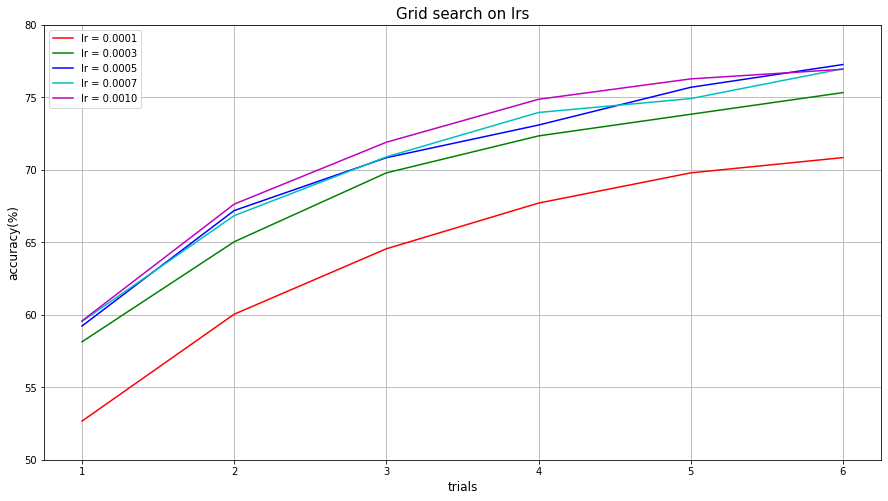

In [ ]:
result = [[52.67     ,  60.04333333, 64.55666667 ,67.71  ,     69.79333333 ,70.84666667],
 [58.14       ,65.04       ,69.79333333 ,72.34333333 ,73.83666667, 75.33      ],
 [59.23       ,67.19333333 ,70.84       ,73.09333333 ,75.69666667, 77.26666667],
 [59.54333333 ,66.84333333 ,70.89666667 ,73.96       ,74.91666667, 76.98      ],
 [59.58333333 ,67.63666667 ,71.90666667 ,74.87       ,76.27666667, 76.94      ]]
lrs = [0.0001, 0.0003, 0.0005, 0.0007, 0.001]
trials = [i+1 for i in range(6)]
color = ['r','g','b','c','m','y']

plt.rcParams['figure.figsize'] = (15,8)
for k in range(5):
    plt.plot(trials, result[k], c = color[k], label = "lr = %.4f"%lrs[k])
    plt.title("Grid search on lrs", fontsize = 15);plt.ylim(50,80)
    plt.xlabel("trials", fontsize = 12);plt.ylabel("accuracy(%)", fontsize = 12)
    plt.grid()
plt.legend()
plt.show()

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

_Tell us here_<br><br>
I fitted the criteria on this task, comprising 4 trials below : <br><br>
#1. Designing the architecture of the net.# 
In the first stage, I planned to construct the net with three parts : head/body/tail. In the head, i.e. the input layer, i stacked<br>
**3x3 Conv - ELU - 5x5 Conv w/ padding=1 - Batch norm - Max pool w/ size and stride 2 - 5x5 Conv w/ padding=1 - ELU**.<br>
Hence the input for the body sequence will be depth of 24 with the size of 12x12. The body sequence consists three inception modues with one convolution layer between the modules. This gives us the output of depth 4096 with the size 4x4. <br>
#2. Comparison between ReLU and ELU#
There are results from study that ELU generally outperforms ReLU in deeper nets. Here i tested both activation functions 3 times each with the same condition(eopch = 2, batch size of 8). the mean for the ReLU have 65% accuracy while ELU have 66.7% accuracy for the test set. According to https://arxiv.org/pdf/1511.07289.pdf , ELU has better generalization performance than ReLU. Therefore in this assignment, I choose ELU as a activation function.<br>
#3. Depth and the learning rate#
Here I performed examinations on the effect of depth - with 2, 3 inception modules and with 4 inception modules -. The table shows the mean loss of three trials after training one epoch, with each depths and fixed learning rate(0.001).<br>

| | | Table 1 | | | 
| --- | --- | --- | --- | --- | 
| Depth(# of module) | 108(2) | 144(2) | 256(3) | 512(4) |
| Loss | 1.288 | 1.215 | 1.148 | 1.309 |

Therefore using the three-layer structure will give us a better net.<br>
Now for the learning rate, i tested five lrs, 0.002, 0.0015, 0.001, 0.0007, 0.0005 with each 3 trials for the three-inception layer structure. Again thre results are summerized below. 

| | | Table 2 | | | |
| --- | --- | --- | --- | --- | ---|
| Learning rate | 0.002 | 0.0015 | 0.001 | 0.0007 | 0.0005 |
| Loss | 1.255 | 1.259 | 1.201 | 1.159 | 1.187 |

So, I choose 0.0007 to be the final learning rate. 

#4. Effect of dropout and optimizer 
I tried to apply dropout2D in the middle of the body sequence, however I found the result more inaccurate than the previous trials. The table below shows the result applying dropout in the conditions given in **Table 2.**

| | | Table 3 | | | |
| --- | --- | --- | --- | --- | ---|
| Learning rate | 0.002 | 0.0015 | 0.001 | 0.0007 | 0.0005 |
| Loss(with dropout) | 1.371 | 1.377 | 1.334 | 1.218 | 1.272 |

Eventually gives more large loss. This result is thought to be from the shallow depth of the neural net architecture. From this, I decided to omit the deopout. <br>

Finally, i modified the hyperparameters below  : <br>
- Increased the input size for the tail sequence 4x4 to 6x6
- Reconstruct the body sequence to Inception - Inception - Maxpool2D(2,2) - Inception, with the depth of 216.
- Increased the epoch number 2 to 4 : further training.<br>
 However, when i set the lr = 0.0006 and 0.0005 for epoch=4 case, I got the maximum accuracy of 75%, 74%. So, the final learning rate will fixed as 0.0006.The mean values are written below : 
- **Mean accuracy for 5 trials, lr = 0.0007 : 73.1%**
- **Mean accuracy for 5 trials, lr = 0.0006 : 73.8%** 
- **Mean accuracy for 5 trials, lr = 0.0005 : 72.5%** <br><br>

#Final architecture#
||Head|||
| --- | --- | --- | --- |
| Function | Ipt size(depth, row, column) | Opt size| Activation|
|Conv2d(3, 8, 3, 1, padding 0)|3, 32, 32|8, 30,30| ELU|
|Conv2d(8, 16, 5, 1, padding 1)|8,30,30|16,28,28| None|
|BatchNorm2d(16)|Same|Same|ELU|
|MaxPool2d(2,2)|Same|16,14,14|None|
|Conv2d(16, 24, 5, 1, padding=1)|16,14,14|24,12,12|ELU|

||Body|||
| --- | --- | --- | --- |
| Function | Ipt size(depth, row, column) | Opt size| Activation|
|Inception(24, 12, 12, 24, 12, 24, 12)|24,12,12|72,12,12| ReLU |
|Inception(72, 24, 24, 48, 24, 48, 24)|72,12,12|144,12,12|ReLU|
|MaxPool2d(2,2)|Same|144,6,6|None|
|Inception(144, 36, 36, 72, 36, 72, 36)|144,6,6|216,6,6|ReLU|

|||Tail      ||
| --- | --- | --- | --- |
| Function | Ipt size(1d vector) | Opt size|Activation|
|Linear|7776|512|ELU|
|Linear|512|64|ELU|
|Linear|64|10|ELU|
